## This notebook presents the reproducible procedure that we followed in comparing the performance of Hybrid Quantum-Classical Neural Networks and Classical Convolutional Neural Networks on the APTOS-2019 dataset. The APTOS dataset is a diabetic-retinopathy dataset with 3662 fundus images. The dataset was produced in France and is labeled with five-category classification (no diabetic retinopathy, mild diabetic retinopathy, moderate diabetic retinopathy, severe diabetic retinopathy, and proliferative diabetic retinopathy).

### Installing and Importing Dependencies

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 70.0 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from google.colab import drive
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Sampler
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import time
import os
import copy
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve,
    precision_recall_curve, auc
)
from sklearn.preprocessing import label_binarize
import random


os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Resnet-18-APTOS_models/"

### General Training, Validation, Testing Functions

In [ ]:
import torchvision
from torchvision import datasets, transforms

In [ ]:
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_probs = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        probs = torch.softmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())



    avg_train_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total * 100

    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_train_loss, accuracy, avg_auroc

In [ ]:
def validate_model(model, valid_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader.dataset)
    accuracy = correct / total * 100
    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_val_loss, accuracy, avg_auroc

In [ ]:
import pickle

def train_validate_model(n_epochs, model, model_name, train_loader, valid_loader, seed):

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

  def adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max):
        if epoch < lr_warmup_epochs:
            lr = lr_max * (epoch + 1) / lr_warmup_epochs
        else:
            lr = lr_max
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

  scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs - 10, eta_min=1e-6)

  best_val_loss = float('inf')
  best_model_weights = model.state_dict()
  epochs_without_improvement = 0
  early_stopping_patience = 10

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  train_aucs = []
  val_aucs = []

  lr_max = 5e-4
  lr_warmup_epochs = 10

  for epoch in range(n_epochs):
      print(f'Epoch [{epoch+1}/{n_epochs}]')

      adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max)

      train_loss, train_accuracy, train_auroc = train_model(model, train_loader, optimizer, criterion)
      val_loss, val_accuracy, val_auroc = validate_model(model, valid_loader, criterion)


      print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Training AUROC: {train_auroc:.4f}')
      print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation AUROC: {val_auroc:.4f}')
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      train_aucs.append(train_auroc)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)
      val_aucs.append(val_auroc)

      if epoch >= lr_warmup_epochs:
            scheduler.step()

      if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            epochs_without_improvement = 0  # Reset counter

      else:
            epochs_without_improvement += 1

      if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

  model.load_state_dict(best_model_weights)
  torch.save(model, os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}.pth'))

  metrics = {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "train_aucs": train_aucs,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "val_aucs": val_aucs
    }

  with open(os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}_metrics.pkl'), 'wb') as f:
        pickle.dump(metrics, f)


  return model, train_losses, train_accuracies, val_losses, val_accuracies, train_aucs, val_aucs

In [ ]:
import math
import matplotlib.pyplot as plt

def plot(quantum_loss, normal_loss, quantum_acc, normal_acc, quantum_auc, normal_auc):
    plt.style.use("default")

    loss_min = math.floor(min(min(quantum_loss), min(normal_loss)) * 10) / 10
    loss_max = math.ceil(max(max(quantum_loss), max(normal_loss)) * 10) / 10

    acc_min = math.floor(min(min(quantum_acc), min(normal_acc)) * 10) / 10
    acc_max = math.ceil(max(max(quantum_acc), max(normal_acc)) * 10) / 10

    auc_min = math.floor(min(min(quantum_auc), min(normal_auc)) * 10) / 10
    auc_max = math.ceil(max(max(quantum_auc), max(normal_auc)) * 10) / 10

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_loss, label="With quantum layer")
    plt.plot(normal_loss, label="Without quantum layer")
    plt.ylabel("Loss")
    plt.ylim([loss_min, loss_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Loss vs. Epoch")
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_acc, label="With quantum layer")
    plt.plot(normal_acc, label="Without quantum layer")
    plt.ylabel("Accuracy")
    plt.ylim([acc_min, acc_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Accuracy vs. Epoch")
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_auc, label="With quantum layer")
    plt.plot(normal_auc, label="Without quantum layer")
    plt.ylabel("ROCAUC")
    plt.ylim([auc_min, auc_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("ROCAUC vs. Epoch")
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.preprocessing import label_binarize
from itertools import cycle

def test(model_hybrid, model_normal, test_loader, num_classes):
    model_hybrid.eval()
    model_normal.eval()

    all_labels = []
    all_preds_hybrid = []
    all_preds_normal = []
    all_probs_hybrid = []
    all_probs_normal = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs_hybrid = model_hybrid(images)
            _, preds_hybrid = torch.max(outputs_hybrid, 1)
            probs_hybrid = torch.softmax(outputs_hybrid, dim=1)

            outputs_normal = model_normal(images)
            _, preds_normal = torch.max(outputs_normal, 1)
            probs_normal = torch.softmax(outputs_normal, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds_hybrid.extend(preds_hybrid.cpu().numpy())
            all_preds_normal.extend(preds_normal.cpu().numpy())
            all_probs_hybrid.extend(probs_hybrid.cpu().numpy())
            all_probs_normal.extend(probs_normal.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds_hybrid = np.array(all_preds_hybrid)
    all_preds_normal = np.array(all_preds_normal)
    all_probs_hybrid = np.array(all_probs_hybrid)
    all_probs_normal = np.array(all_probs_normal)

    accuracy_hybrid = accuracy_score(all_labels, all_preds_hybrid)
    accuracy_normal = accuracy_score(all_labels, all_preds_normal)

    f1_hybrid = f1_score(all_labels, all_preds_hybrid, average='weighted')
    f1_normal = f1_score(all_labels, all_preds_normal, average='weighted')

    if num_classes == 2:
        precision_hybrid = precision_score(all_labels, all_preds_hybrid, pos_label=1)
        recall_hybrid = recall_score(all_labels, all_preds_hybrid, pos_label=1)
        precision_normal = precision_score(all_labels, all_preds_normal, pos_label=1)
        recall_normal = recall_score(all_labels, all_preds_normal, pos_label=1)
    else:
        precision_hybrid = precision_score(all_labels, all_preds_hybrid, average='weighted')
        recall_hybrid = recall_score(all_labels, all_preds_hybrid, average='weighted')
        precision_normal = precision_score(all_labels, all_preds_normal, average='weighted')
        recall_normal = recall_score(all_labels, all_preds_normal, average='weighted')

    hybrid_aucs = []
    normal_aucs = []

    # ROC data to store for plotting later
    roc_data = {
        "fpr_hybrid": [],
        "tpr_hybrid": [],
        "auc_hybrid": [],
        "fpr_normal": [],
        "tpr_normal": [],
        "auc_normal": []
    }

    if num_classes == 2:
        all_probs_hybrid_class1 = all_probs_hybrid[:, 1]
        all_probs_normal_class1 = all_probs_normal[:, 1]

        auc_hybrid = roc_auc_score(all_labels, all_probs_hybrid_class1)
        auc_normal = roc_auc_score(all_labels, all_probs_normal_class1)

        print(f'Hybrid Model AUROC: {auc_hybrid:.4f}')
        print(f'Normal Model AUROC: {auc_normal:.4f}')

        fpr_hybrid, tpr_hybrid, _ = roc_curve(all_labels, all_probs_hybrid_class1)
        fpr_normal, tpr_normal, _ = roc_curve(all_labels, all_probs_normal_class1)

        roc_data["fpr_hybrid"].append(fpr_hybrid)
        roc_data["tpr_hybrid"].append(tpr_hybrid)
        roc_data["auc_hybrid"].append(auc_hybrid)
        roc_data["fpr_normal"].append(fpr_normal)
        roc_data["tpr_normal"].append(tpr_normal)
        roc_data["auc_normal"].append(auc_normal)

        # Hybrid
        plt.figure(figsize=(10, 6))
        plt.plot(fpr_hybrid, tpr_hybrid, label=f'Hybrid Model AUROC = {auc_hybrid:.4f}', linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve - Hybrid Model', fontsize=18)
        plt.xlabel('False Positive Rate', fontsize=14)
        plt.ylabel('True Positive Rate', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(loc='lower right', fontsize=12)
        plt.grid(True)
        plt.show()

        # Normal
        plt.figure(figsize=(10, 6))
        plt.plot(fpr_normal, tpr_normal, label=f'Normal Model AUROC = {auc_normal:.4f}', linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve - Normal Model', fontsize=18)
        plt.xlabel('False Positive Rate', fontsize=14)
        plt.ylabel('True Positive Rate', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(loc='lower right', fontsize=12)
        plt.grid(True)
        plt.show()

    else:  # Multi-class
        all_labels_binarized = label_binarize(all_labels, classes=np.arange(num_classes))
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])

        plt.figure(figsize=(10, 8))
        for i, color in zip(range(num_classes), colors):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs_hybrid[:, i])
            roc_auc = auc(fpr, tpr)
            hybrid_aucs.append(roc_auc)
            roc_data["fpr_hybrid"].append(fpr)
            roc_data["tpr_hybrid"].append(tpr)
            roc_data["auc_hybrid"].append(roc_auc)
            plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlabel('False Positive Rate', fontsize=14)
        plt.ylabel('True Positive Rate', fontsize=14)
        plt.title('ROC Curves - Hybrid Model', fontsize=18)
        plt.legend(loc='lower right', fontsize=12)
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 8))
        for i, color in zip(range(num_classes), colors):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs_normal[:, i])
            roc_auc = auc(fpr, tpr)
            normal_aucs.append(roc_auc)
            roc_data["fpr_normal"].append(fpr)
            roc_data["tpr_normal"].append(tpr)
            roc_data["auc_normal"].append(roc_auc)
            plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlabel('False Positive Rate', fontsize=14)
        plt.ylabel('True Positive Rate', fontsize=14)
        plt.title('ROC Curves - Normal Model', fontsize=18)
        plt.legend(loc='lower right', fontsize=12)
        plt.grid(True)
        plt.show()

    hybrid_auc_avg = f"{sum(hybrid_aucs) / len(hybrid_aucs):.4f}" if hybrid_aucs else f"{auc_hybrid:.4f}"
    normal_auc_avg = f"{sum(normal_aucs) / len(normal_aucs):.4f}" if normal_aucs else f"{auc_normal:.4f}"

    print("\nHybrid Model Metrics:")
    print(f'Accuracy: {accuracy_hybrid:.4f}')
    print(f'F1 Score: {f1_hybrid:.4f}')
    print(f'Precision: {precision_hybrid:.4f}')
    print(f'Recall: {recall_hybrid:.4f}')
    print(f'AUROC: {hybrid_auc_avg}')

    print("\nNormal Model Metrics:")
    print(f'Accuracy: {accuracy_normal:.4f}')
    print(f'F1 Score: {f1_normal:.4f}')
    print(f'Precision: {precision_normal:.4f}')
    print(f'Recall: {recall_normal:.4f}')
    print(f'AUROC: {normal_auc_avg}\n')

    cm_hybrid = confusion_matrix(all_labels, all_preds_hybrid)
    cm_normal = confusion_matrix(all_labels, all_preds_normal)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: Hybrid Model (Avg AUC = {hybrid_auc_avg})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normal, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: Classical Model (Avg AUC = {normal_auc_avg})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    test_results = {
        "roc_data": roc_data
    }

    os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
    with open(os.path.join(MODEL_SAVE_PATH, f'{seed}_test_results.pkl'), 'wb') as f:
        pickle.dump(test_results, f)

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
def load_data(batch_size, dataset):

  train_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  valid_test_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])


  if dataset == 'APTOS':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS2019/"

  elif dataset == "IDRID":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_images/"

  elif dataset == "Messidor":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR2/"

  elif dataset == "GlaucomaFundus":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Glaucoma_fundus/"

  elif dataset == "PAPILA":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA/"

  elif dataset == 'G1020':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020/"


  train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=train_transform)
  val_dataset = datasets.ImageFolder(root=data_dir + 'val', transform=valid_test_transform)
  test_dataset = datasets.ImageFolder(root=data_dir + 'test', transform=valid_test_transform)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
  valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

  return train_loader, valid_loader, test_loader

### Classical Resnet-18 Construction

In [ ]:
class NormalModel(nn.Module):
  def __init__(self, freeze, num_classes, device='cuda'):
        super(NormalModel, self).__init__()

        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        self.model = torchvision.models.resnet18(weights=weights)

        if freeze:
          for param in self.model.parameters():
              param.requires_grad = False

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.model = self.model.to(device)

  def forward(self, x):
        return self.model(x)

### Hybrid Quantum-Classical Resnet-18 Construction

In [ ]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    for i in range(0, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])

In [ ]:
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [ ]:
class DressedQuantumNet(nn.Module):

    def __init__(self, q_depth, num_classes):

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, num_classes)

    def forward(self, input_features):


        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [ ]:
class QuantumHybridModel(nn.Module):
  def __init__(self, q_depth, freeze, num_classes, device='cuda'):
        super(QuantumHybridModel, self).__init__()

        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        self.model = torchvision.models.resnet18(weights=weights)

        if freeze:
          for param in self.model.parameters():
              param.requires_grad = False

        self.model.fc = DressedQuantumNet(q_depth, num_classes)

        self.model = self.model.to(device)

  def forward(self, x):
        return self.model(x)

# Experiments

In [ ]:
n_epochs = 100
num_classes = 5
batch_size = 32
dataset = "APTOS"
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'
q_depth = 4

## Seed Experiment 1

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=5)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 65:


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.5918, Training Accuracy: 24.37%, Training AUROC: 0.4704
Validation Loss: 1.3960, Validation Accuracy: 38.91%, Validation AUROC: 0.4658
Epoch [2/100]
Training Loss: 1.2887, Training Accuracy: 49.61%, Training AUROC: 0.5654
Validation Loss: 1.2038, Validation Accuracy: 56.03%, Validation AUROC: 0.6522
Epoch [3/100]
Training Loss: 1.1156, Training Accuracy: 62.40%, Training AUROC: 0.7217
Validation Loss: 1.0499, Validation Accuracy: 67.32%, Validation AUROC: 0.7524
Epoch [4/100]
Training Loss: 0.9843, Training Accuracy: 67.09%, Training AUROC: 0.7916
Validation Loss: 0.9530, Validation Accuracy: 67.51%, Validation AUROC: 0.7979
Epoch [5/100]
Training Loss: 0.9028, Training Accuracy: 69.14%, Training AUROC: 0.8249
Validation Loss: 0.8942, Validation Accuracy: 71.21%, Validation AUROC: 0.8099
Epoch [6/100]
Training Loss: 0.8411, Training Accuracy: 71.09%, Training AUROC: 0.8442
Validation Loss: 0.8262, Validation Accuracy: 73.35%, Validation AUROC: 0.8387
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.5641, Training Accuracy: 40.82%, Training AUROC: 0.5277
Validation Loss: 1.4192, Validation Accuracy: 48.83%, Validation AUROC: 0.5785
Epoch [2/100]
Training Loss: 1.3279, Training Accuracy: 56.79%, Training AUROC: 0.6505
Validation Loss: 1.2727, Validation Accuracy: 63.42%, Validation AUROC: 0.6782
Epoch [3/100]
Training Loss: 1.2418, Training Accuracy: 65.14%, Training AUROC: 0.6896
Validation Loss: 1.1972, Validation Accuracy: 68.87%, Validation AUROC: 0.6924
Epoch [4/100]
Training Loss: 1.1772, Training Accuracy: 68.65%, Training AUROC: 0.6995
Validation Loss: 1.1381, Validation Accuracy: 71.21%, Validation AUROC: 0.7034
Epoch [5/100]
Training Loss: 1.1221, Training Accuracy: 70.21%, Training AUROC: 0.7151
Validation Loss: 1.0907, Validation Accuracy: 71.01%, Validation AUROC: 0.7106
Epoch [6/100]
Training Loss: 1.0776, Training Accuracy: 70.31%, Training AUROC: 0.7251
Validation Loss: 1.0470, Validation Accuracy: 71.01%, Validation AUROC: 0.7233
Epoc

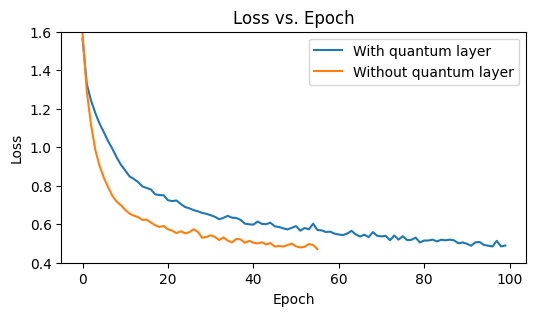

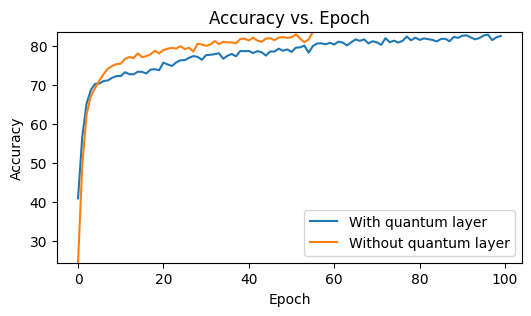

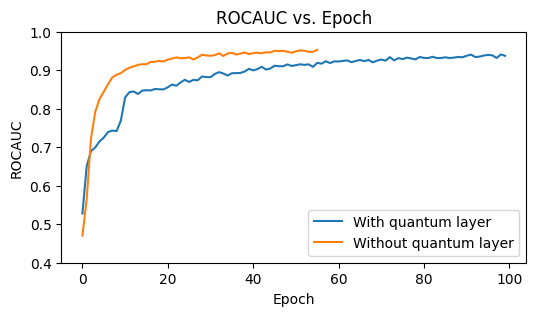

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

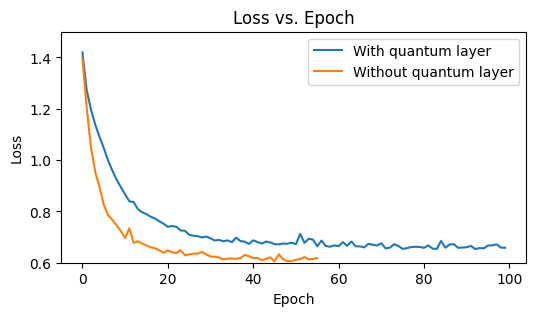

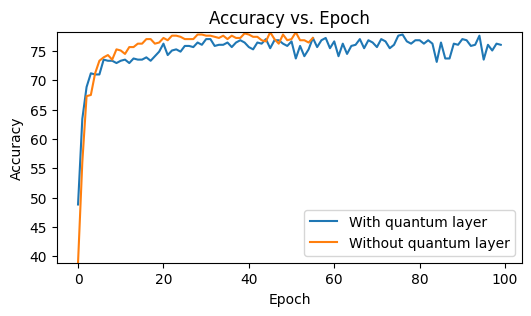

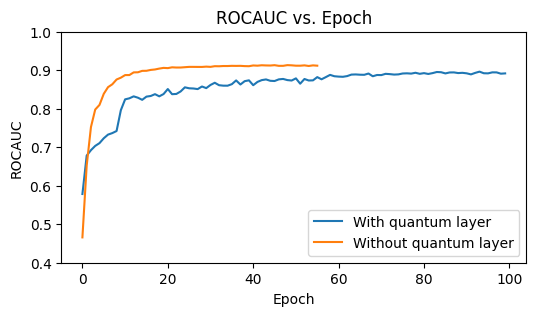

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

In [ ]:
seed=10
model = torch.load(os.path.join(MODEL_SAVE_PATH, f'normal_model_{seed}.pth'), weights_only=False)
hybrid_model = torch.load(os.path.join(MODEL_SAVE_PATH, f'quantum_hybrid_model_{seed}.pth'), weights_only=False)
model_normal=model
model_hybrid=hybrid_model

KeyboardInterrupt: 

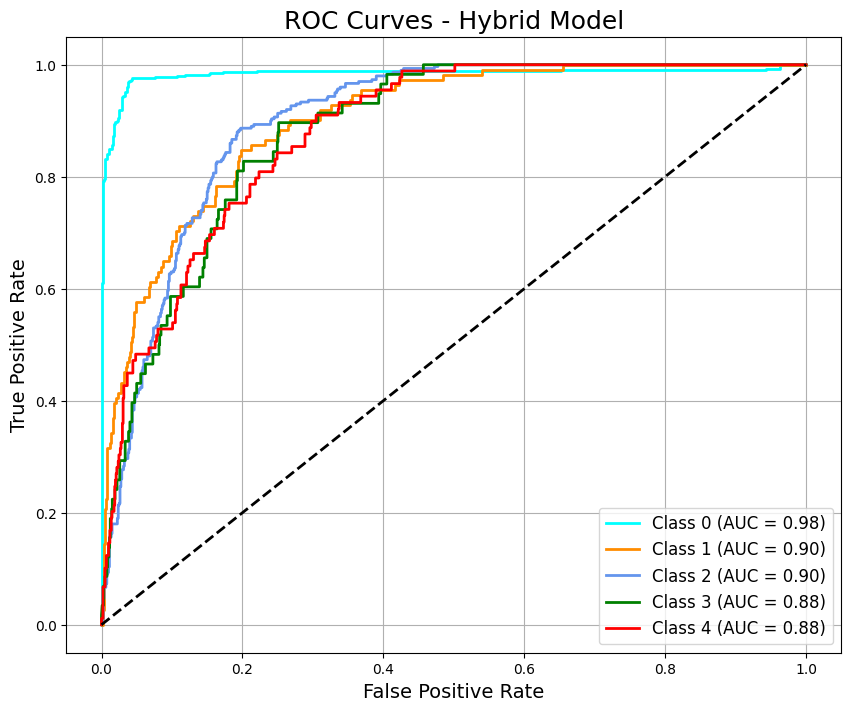

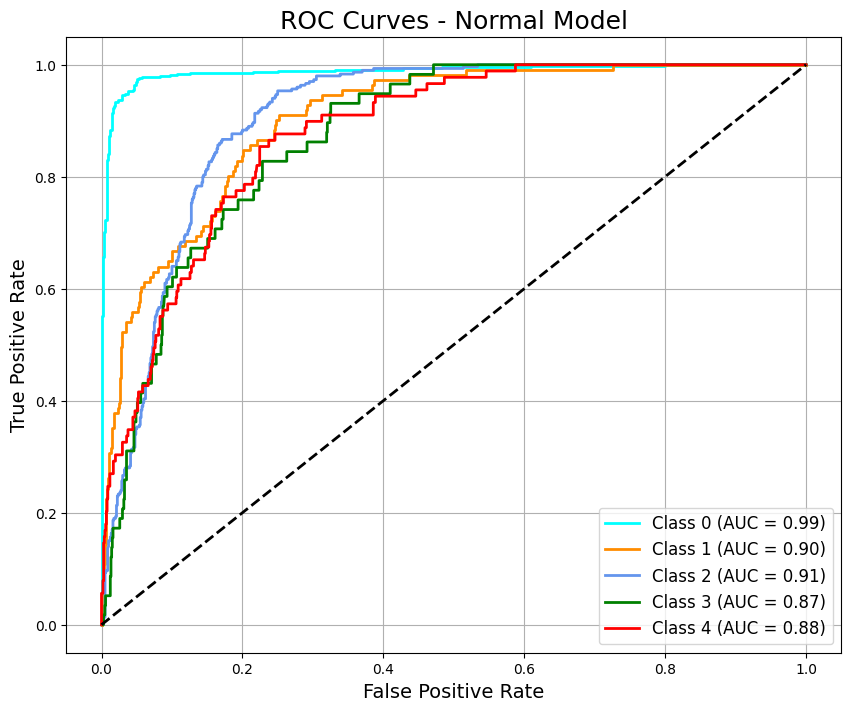


Hybrid Model Metrics:
Accuracy: 0.7827
F1 Score: 0.7699
Precision: 0.7736
Recall: 0.7827
AUROC: 0.9098

Normal Model Metrics:
Accuracy: 0.7845
F1 Score: 0.7652
Precision: 0.7714
Recall: 0.7845
AUROC: 0.9102



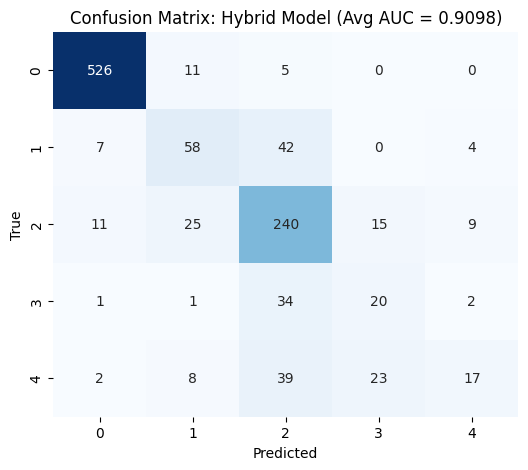

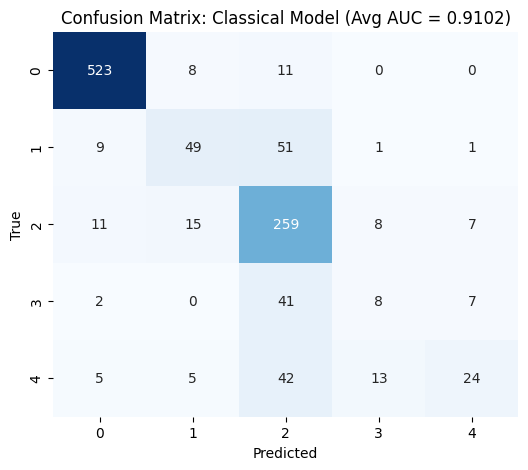

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 2

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=5)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.5292, Training Accuracy: 32.81%, Training AUROC: 0.5167
Validation Loss: 1.3373, Validation Accuracy: 50.78%, Validation AUROC: 0.5117
Epoch [2/100]
Training Loss: 1.2295, Training Accuracy: 54.10%, Training AUROC: 0.6057
Validation Loss: 1.1832, Validation Accuracy: 56.81%, Validation AUROC: 0.6499
Epoch [3/100]
Training Loss: 1.1000, Training Accuracy: 60.74%, Training AUROC: 0.7143
Validation Loss: 1.0562, Validation Accuracy: 63.42%, Validation AUROC: 0.7478
Epoch [4/100]
Training Loss: 0.9821, Training Accuracy: 66.75%, Training AUROC: 0.7886
Validation Loss: 0.9528, Validation Accuracy: 68.68%, Validation AUROC: 0.8054
Epoch [5/100]
Training Loss: 0.8983, Training Accuracy: 68.90%, Training AUROC: 0.8317
Validation Loss: 0.8846, Validation Accuracy: 69.84%, Validation AUROC: 0.8350
Epoch [6/100]
Training Loss: 0.8399, Training Accuracy: 70.46%, Training AUROC: 0.8518
Validation Loss: 0.8315, Validation Accuracy: 70.62%, Validation AUROC: 0.8541
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.6615, Training Accuracy: 20.65%, Training AUROC: 0.5244
Validation Loss: 1.4567, Validation Accuracy: 37.55%, Validation AUROC: 0.5831
Epoch [2/100]
Training Loss: 1.4137, Training Accuracy: 50.24%, Training AUROC: 0.5864
Validation Loss: 1.3887, Validation Accuracy: 57.98%, Validation AUROC: 0.6141
Epoch [3/100]
Training Loss: 1.3742, Training Accuracy: 58.94%, Training AUROC: 0.6557
Validation Loss: 1.3492, Validation Accuracy: 65.76%, Validation AUROC: 0.6697
Epoch [4/100]
Training Loss: 1.3310, Training Accuracy: 65.77%, Training AUROC: 0.6818
Validation Loss: 1.3057, Validation Accuracy: 68.29%, Validation AUROC: 0.6874
Epoch [5/100]
Training Loss: 1.2758, Training Accuracy: 68.36%, Training AUROC: 0.6660
Validation Loss: 1.2372, Validation Accuracy: 70.23%, Validation AUROC: 0.6435
Epoch [6/100]
Training Loss: 1.2071, Training Accuracy: 69.68%, Training AUROC: 0.6584
Validation Loss: 1.1791, Validation Accuracy: 71.60%, Validation AUROC: 0.6301
Epoc

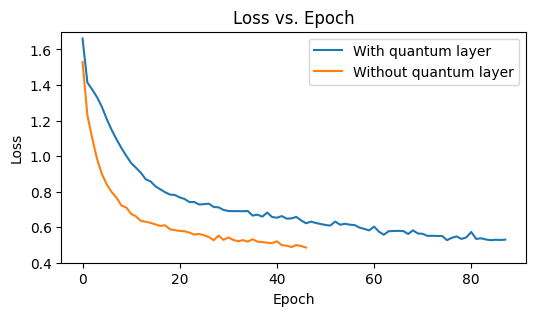

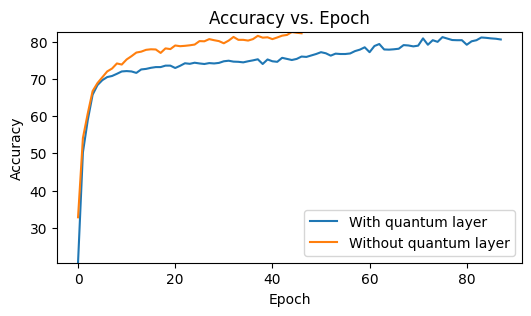

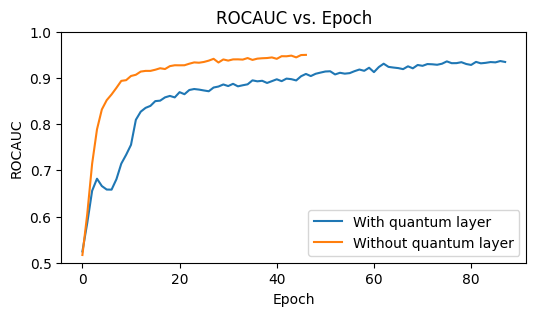

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

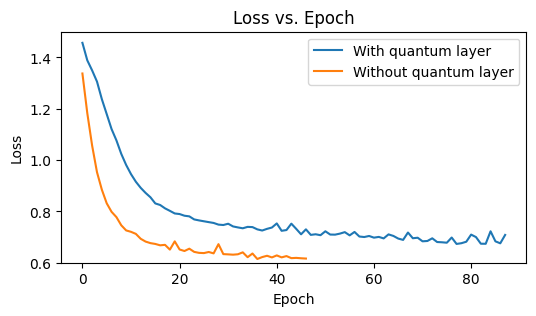

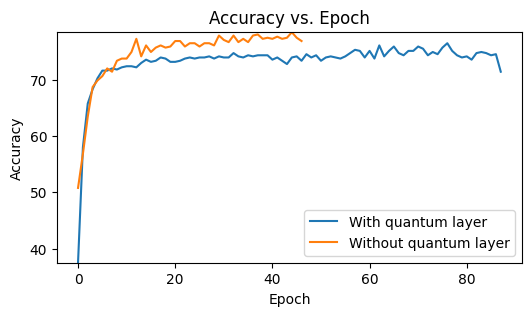

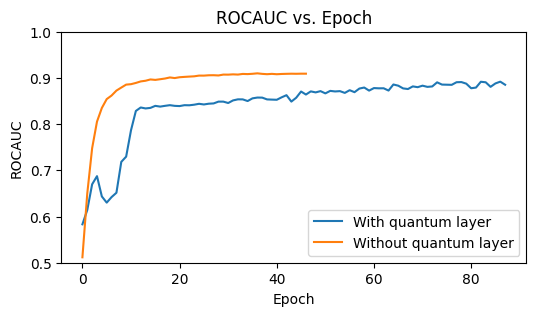

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

In [ ]:
seed=16
model = torch.load(os.path.join(MODEL_SAVE_PATH, f'normal_model_{seed}.pth'), weights_only=False)
hybrid_model = torch.load(os.path.join(MODEL_SAVE_PATH, f'quantum_hybrid_model_{seed}.pth'), weights_only=False)
model_normal=model
model_hybrid=hybrid_model

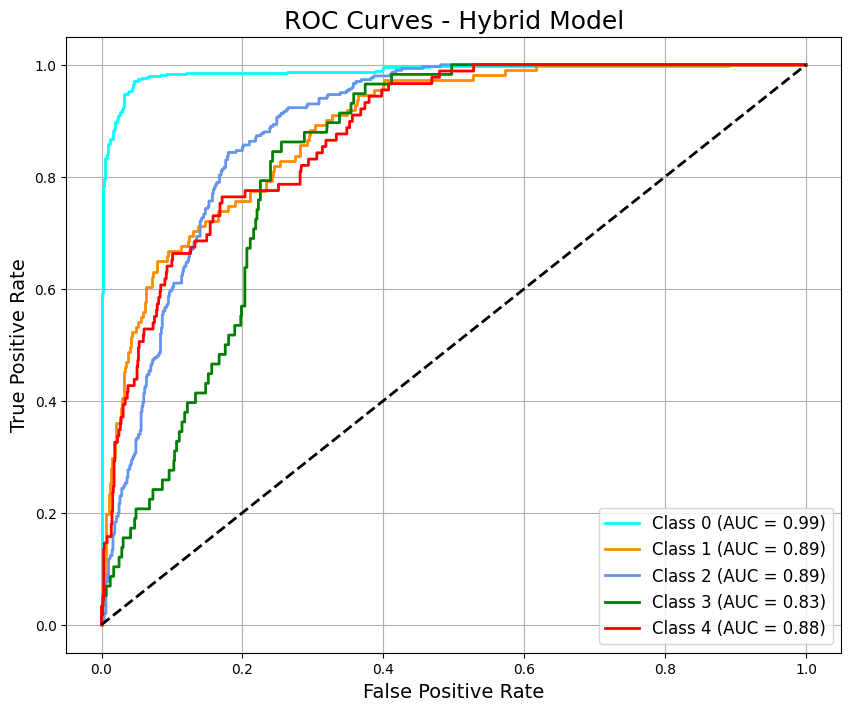

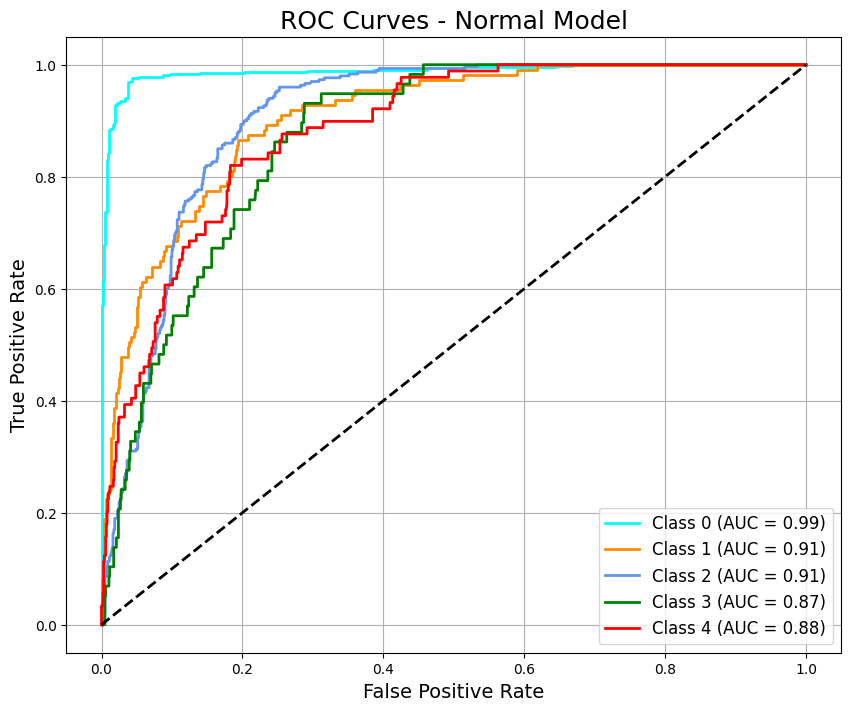


Hybrid Model Metrics:
Accuracy: 0.7755
F1 Score: 0.7476
Precision: 0.7504
Recall: 0.7755
AUROC: 0.8958

Normal Model Metrics:
Accuracy: 0.7773
F1 Score: 0.7575
Precision: 0.7505
Recall: 0.7773
AUROC: 0.9113



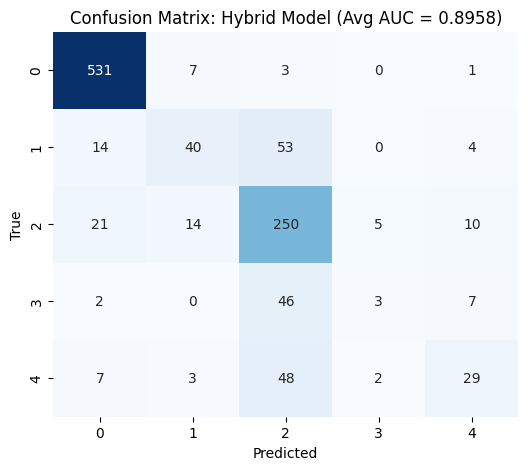

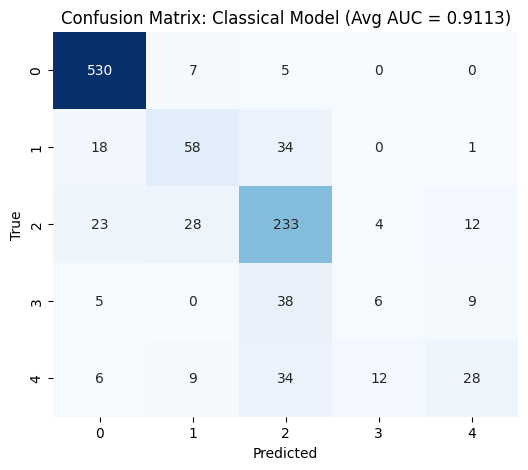

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 3

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=5)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 18:


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.4667, Training Accuracy: 33.11%, Training AUROC: 0.5062
Validation Loss: 1.3359, Validation Accuracy: 45.53%, Validation AUROC: 0.5173
Epoch [2/100]
Training Loss: 1.2466, Training Accuracy: 52.64%, Training AUROC: 0.6121
Validation Loss: 1.1716, Validation Accuracy: 56.03%, Validation AUROC: 0.6980
Epoch [3/100]
Training Loss: 1.1012, Training Accuracy: 59.13%, Training AUROC: 0.7475
Validation Loss: 1.0365, Validation Accuracy: 65.95%, Validation AUROC: 0.7819
Epoch [4/100]
Training Loss: 0.9810, Training Accuracy: 66.16%, Training AUROC: 0.8046
Validation Loss: 0.9318, Validation Accuracy: 70.04%, Validation AUROC: 0.8234
Epoch [5/100]
Training Loss: 0.8971, Training Accuracy: 68.70%, Training AUROC: 0.8360
Validation Loss: 0.8752, Validation Accuracy: 71.79%, Validation AUROC: 0.8422
Epoch [6/100]
Training Loss: 0.8287, Training Accuracy: 71.24%, Training AUROC: 0.8574
Validation Loss: 0.8246, Validation Accuracy: 69.46%, Validation AUROC: 0.8604
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.5044, Training Accuracy: 43.75%, Training AUROC: 0.4784
Validation Loss: 1.4356, Validation Accuracy: 49.22%, Validation AUROC: 0.5400
Epoch [2/100]
Training Loss: 1.3975, Training Accuracy: 49.56%, Training AUROC: 0.5998
Validation Loss: 1.3296, Validation Accuracy: 56.03%, Validation AUROC: 0.6414
Epoch [3/100]
Training Loss: 1.2772, Training Accuracy: 63.87%, Training AUROC: 0.6707
Validation Loss: 1.2276, Validation Accuracy: 71.21%, Validation AUROC: 0.6880
Epoch [4/100]
Training Loss: 1.1998, Training Accuracy: 68.65%, Training AUROC: 0.7054
Validation Loss: 1.1639, Validation Accuracy: 71.79%, Validation AUROC: 0.7056
Epoch [5/100]
Training Loss: 1.1454, Training Accuracy: 69.97%, Training AUROC: 0.7199
Validation Loss: 1.1095, Validation Accuracy: 72.37%, Validation AUROC: 0.7105
Epoch [6/100]
Training Loss: 1.0868, Training Accuracy: 71.44%, Training AUROC: 0.7287
Validation Loss: 1.0580, Validation Accuracy: 72.37%, Validation AUROC: 0.7142
Epoc

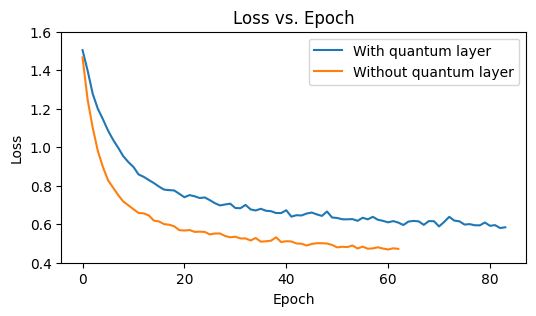

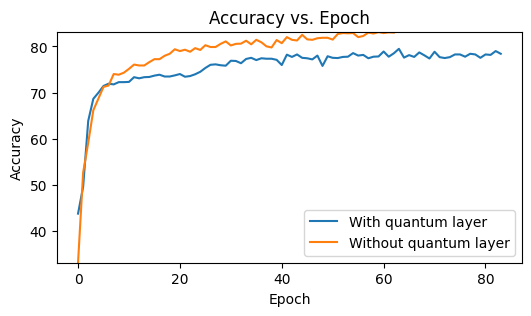

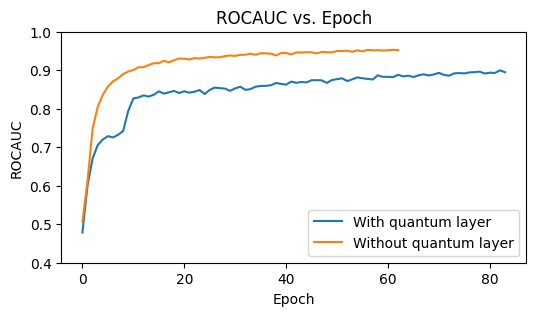

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

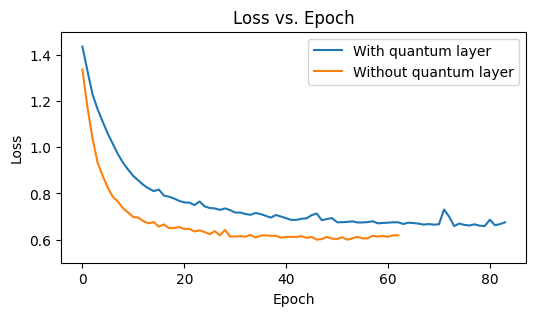

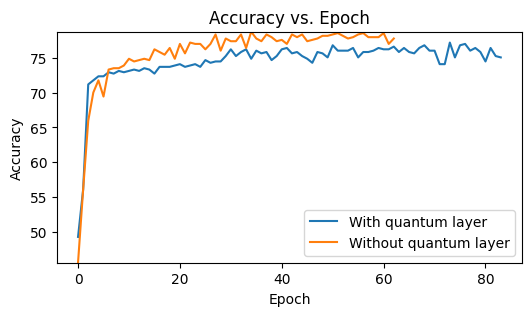

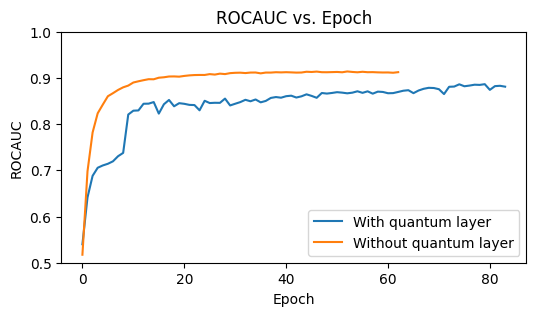

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

RuntimeError: shape '[4, 4]' is invalid for input of size 36

## Seed Experiment 4

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=5)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.5157, Training Accuracy: 31.64%, Training AUROC: 0.5122
Validation Loss: 1.3518, Validation Accuracy: 44.75%, Validation AUROC: 0.5406
Epoch [2/100]
Training Loss: 1.2418, Training Accuracy: 50.73%, Training AUROC: 0.6124
Validation Loss: 1.1716, Validation Accuracy: 54.67%, Validation AUROC: 0.6712
Epoch [3/100]
Training Loss: 1.0906, Training Accuracy: 60.30%, Training AUROC: 0.7258
Validation Loss: 1.0365, Validation Accuracy: 64.40%, Validation AUROC: 0.7562
Epoch [4/100]
Training Loss: 0.9816, Training Accuracy: 66.85%, Training AUROC: 0.7838
Validation Loss: 0.9536, Validation Accuracy: 68.48%, Validation AUROC: 0.7875
Epoch [5/100]
Training Loss: 0.8971, Training Accuracy: 70.41%, Training AUROC: 0.8164
Validation Loss: 0.8780, Validation Accuracy: 71.01%, Validation AUROC: 0.8201
Epoch [6/100]
Training Loss: 0.8463, Training Accuracy: 71.29%, Training AUROC: 0.8347
Validation Loss: 0.8322, Validation Accuracy: 71.98%, Validation AUROC: 0.8383
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.5343, Training Accuracy: 25.73%, Training AUROC: 0.4765
Validation Loss: 1.4889, Validation Accuracy: 27.24%, Validation AUROC: 0.4644
Epoch [2/100]
Training Loss: 1.4715, Training Accuracy: 27.98%, Training AUROC: 0.5022
Validation Loss: 1.4566, Validation Accuracy: 30.93%, Validation AUROC: 0.5686
Epoch [3/100]
Training Loss: 1.4428, Training Accuracy: 31.59%, Training AUROC: 0.5578
Validation Loss: 1.4323, Validation Accuracy: 33.46%, Validation AUROC: 0.5944
Epoch [4/100]
Training Loss: 1.4187, Training Accuracy: 39.99%, Training AUROC: 0.5749
Validation Loss: 1.4073, Validation Accuracy: 48.44%, Validation AUROC: 0.6074
Epoch [5/100]
Training Loss: 1.3932, Training Accuracy: 52.59%, Training AUROC: 0.5881
Validation Loss: 1.3826, Validation Accuracy: 57.78%, Validation AUROC: 0.6166
Epoch [6/100]
Training Loss: 1.3665, Training Accuracy: 57.86%, Training AUROC: 0.6113
Validation Loss: 1.3544, Validation Accuracy: 61.48%, Validation AUROC: 0.6363
Epoc

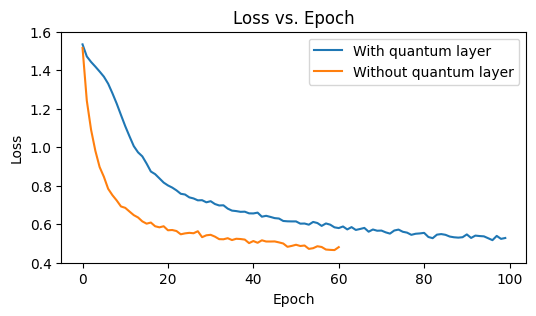

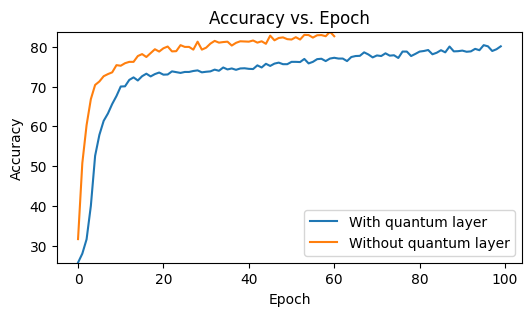

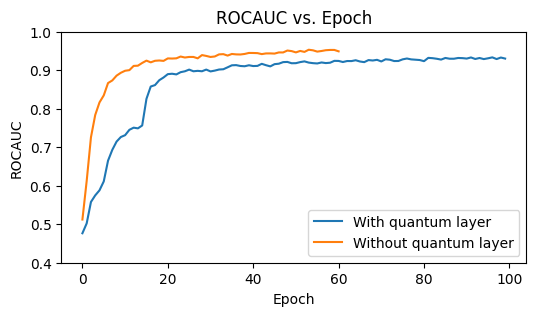

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

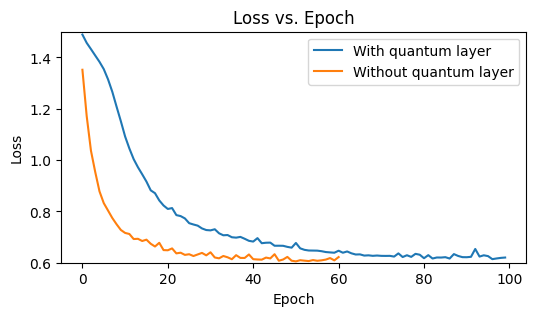

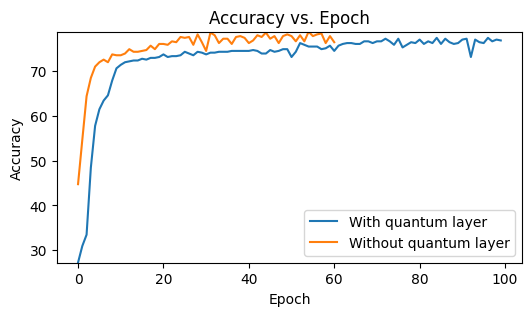

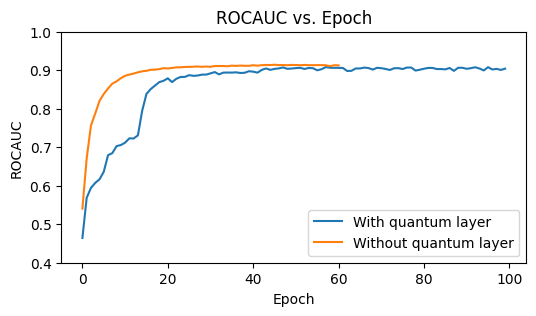

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

In [ ]:
seed=74
model = torch.load(os.path.join(MODEL_SAVE_PATH, f'normal_model_{seed}.pth'), weights_only=False)
hybrid_model = torch.load(os.path.join(MODEL_SAVE_PATH, f'quantum_hybrid_model_{seed}.pth'), weights_only=False)
model_normal=model
model_hybrid=hybrid_model

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


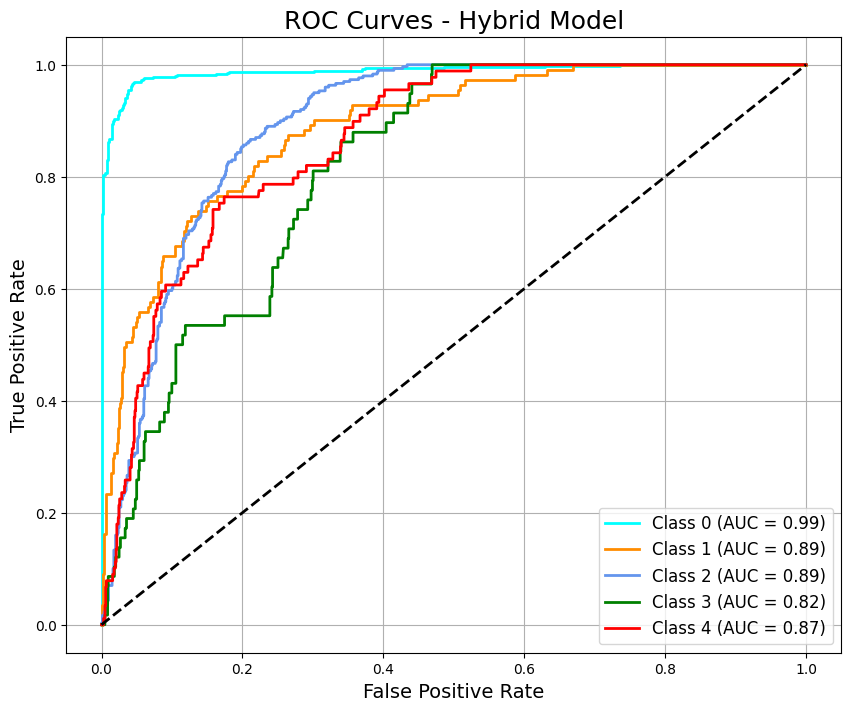

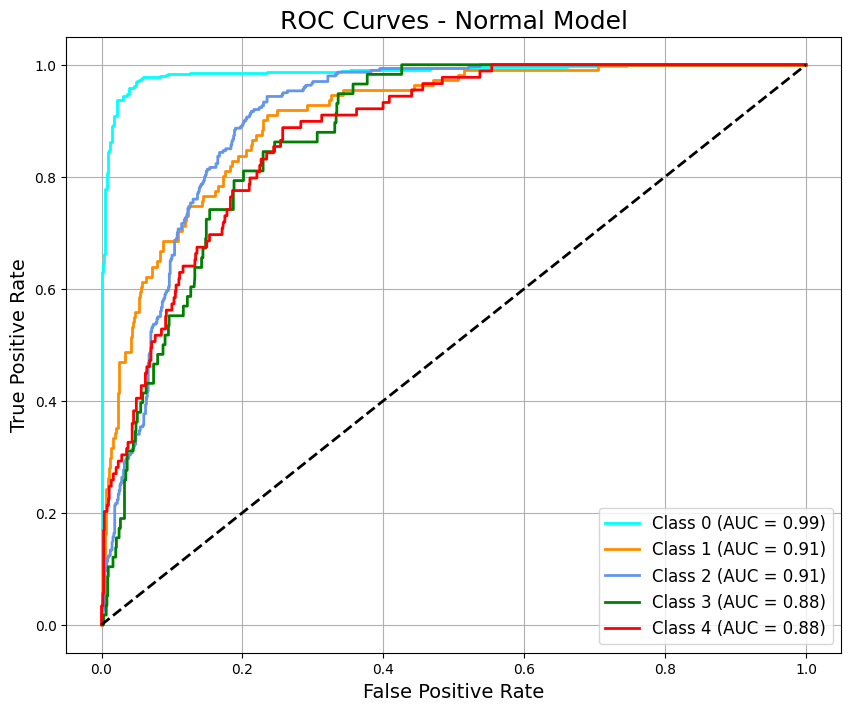


Hybrid Model Metrics:
Accuracy: 0.7691
F1 Score: 0.7334
Precision: 0.7094
Recall: 0.7691
AUROC: 0.8915

Normal Model Metrics:
Accuracy: 0.7745
F1 Score: 0.7671
Precision: 0.7656
Recall: 0.7745
AUROC: 0.9110



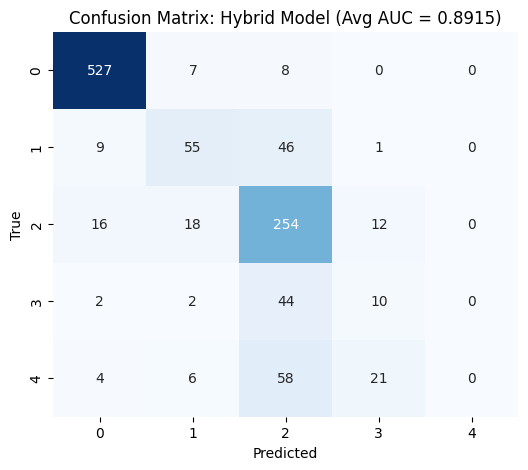

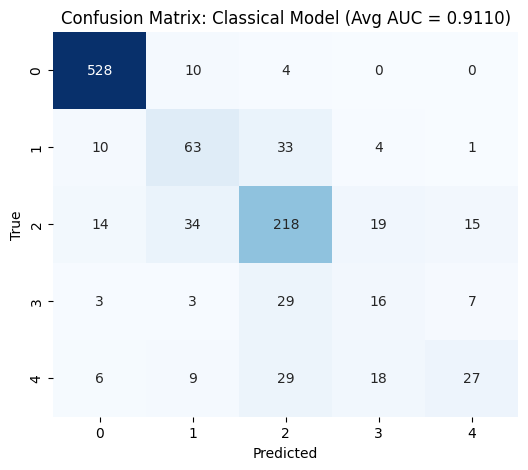

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiment 5

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=5)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 31:


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.4598, Training Accuracy: 35.55%, Training AUROC: 0.5090
Validation Loss: 1.3023, Validation Accuracy: 48.83%, Validation AUROC: 0.5762
Epoch [2/100]
Training Loss: 1.2307, Training Accuracy: 54.15%, Training AUROC: 0.6292
Validation Loss: 1.1489, Validation Accuracy: 57.98%, Validation AUROC: 0.7169
Epoch [3/100]
Training Loss: 1.0860, Training Accuracy: 62.74%, Training AUROC: 0.7475
Validation Loss: 1.0199, Validation Accuracy: 66.34%, Validation AUROC: 0.7892
Epoch [4/100]
Training Loss: 0.9821, Training Accuracy: 67.09%, Training AUROC: 0.8022
Validation Loss: 0.9235, Validation Accuracy: 69.46%, Validation AUROC: 0.8308
Epoch [5/100]
Training Loss: 0.8883, Training Accuracy: 69.53%, Training AUROC: 0.8431
Validation Loss: 0.8578, Validation Accuracy: 70.23%, Validation AUROC: 0.8542
Epoch [6/100]
Training Loss: 0.8177, Training Accuracy: 70.95%, Training AUROC: 0.8662
Validation Loss: 0.8373, Validation Accuracy: 70.82%, Validation AUROC: 0.8594
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.5265, Training Accuracy: 36.96%, Training AUROC: 0.5181
Validation Loss: 1.4038, Validation Accuracy: 49.03%, Validation AUROC: 0.5736
Epoch [2/100]
Training Loss: 1.3568, Training Accuracy: 49.85%, Training AUROC: 0.6029
Validation Loss: 1.3100, Validation Accuracy: 49.81%, Validation AUROC: 0.6394
Epoch [3/100]
Training Loss: 1.2668, Training Accuracy: 57.03%, Training AUROC: 0.6737
Validation Loss: 1.2145, Validation Accuracy: 64.01%, Validation AUROC: 0.7205
Epoch [4/100]
Training Loss: 1.1837, Training Accuracy: 65.58%, Training AUROC: 0.7252
Validation Loss: 1.1490, Validation Accuracy: 68.87%, Validation AUROC: 0.7408
Epoch [5/100]
Training Loss: 1.1356, Training Accuracy: 67.97%, Training AUROC: 0.7375
Validation Loss: 1.1024, Validation Accuracy: 67.32%, Validation AUROC: 0.7590
Epoch [6/100]
Training Loss: 1.0843, Training Accuracy: 69.82%, Training AUROC: 0.7458
Validation Loss: 1.0523, Validation Accuracy: 70.23%, Validation AUROC: 0.7602
Epoc

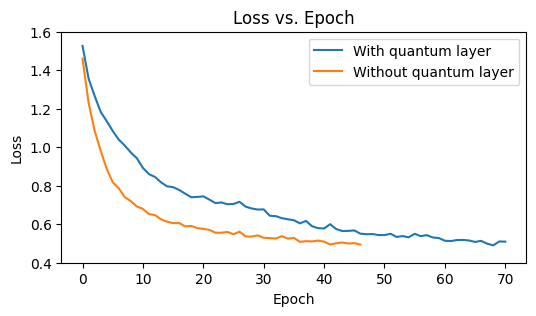

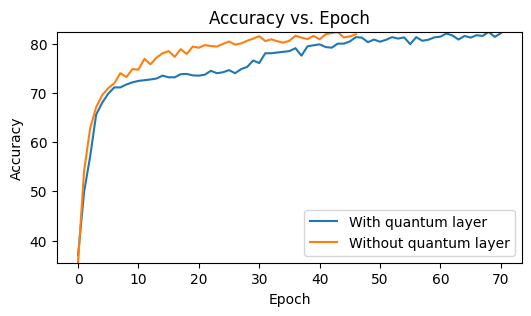

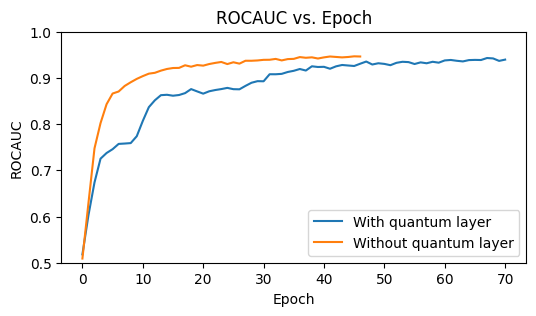

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

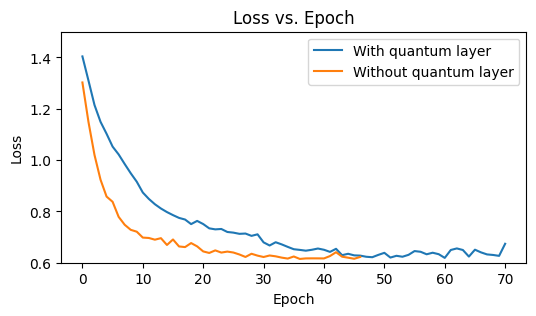

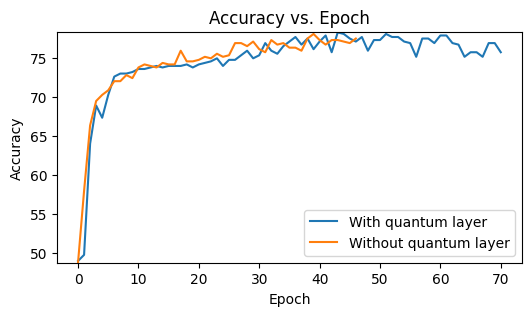

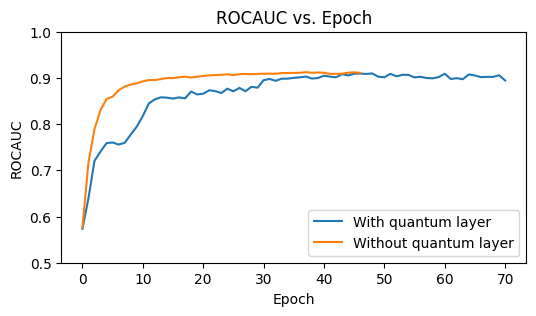

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

In [ ]:
seed=47
model = torch.load(os.path.join(MODEL_SAVE_PATH, f'normal_model_{seed}.pth'), weights_only=False)
hybrid_model = torch.load(os.path.join(MODEL_SAVE_PATH, f'quantum_hybrid_model_{seed}.pth'), weights_only=False)
model_normal=model
model_hybrid=hybrid_model

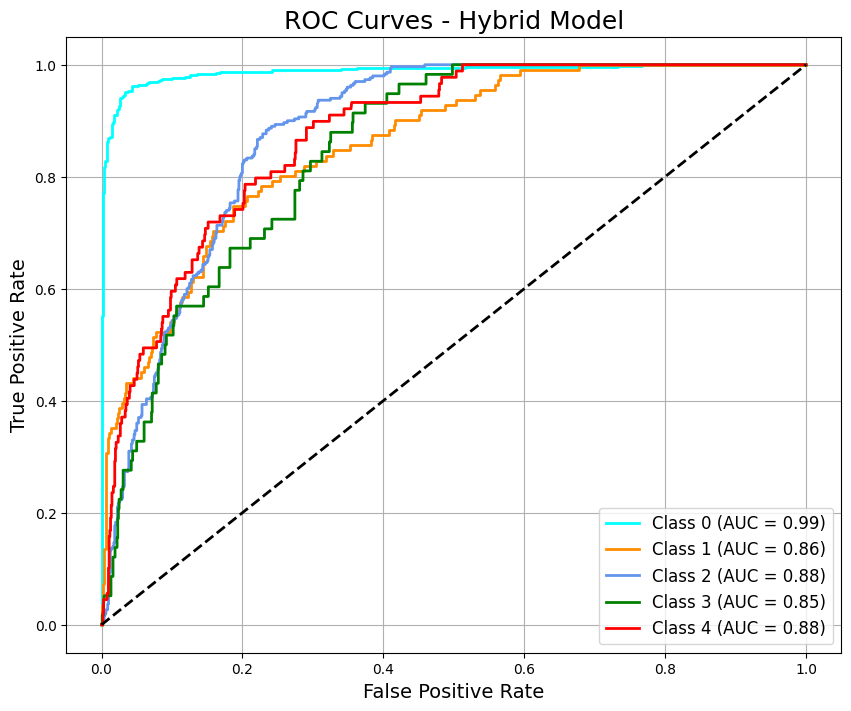

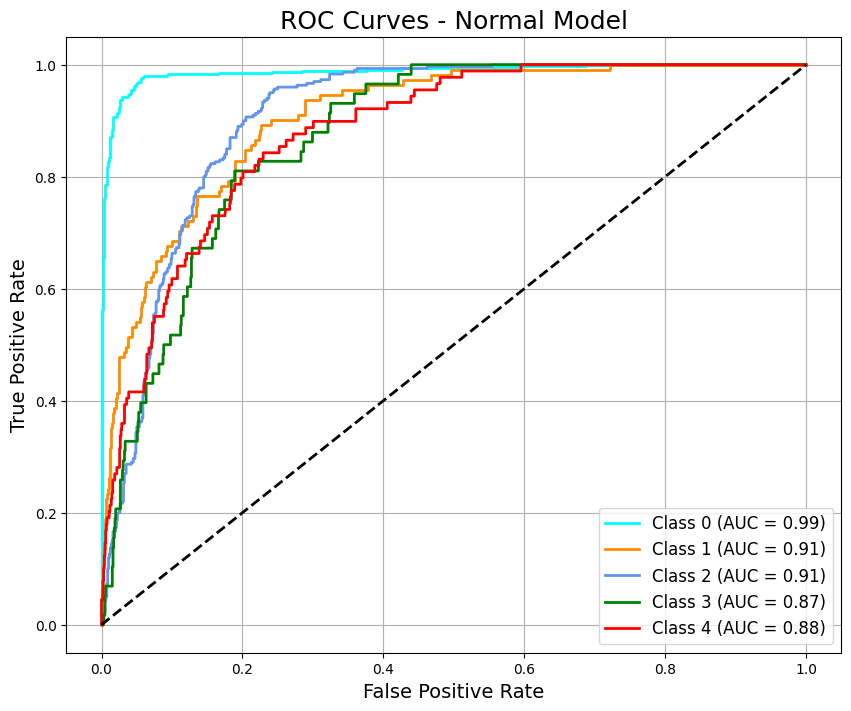


Hybrid Model Metrics:
Accuracy: 0.7427
F1 Score: 0.7365
Precision: 0.7523
Recall: 0.7427
AUROC: 0.8905

Normal Model Metrics:
Accuracy: 0.7736
F1 Score: 0.7592
Precision: 0.7533
Recall: 0.7736
AUROC: 0.9112



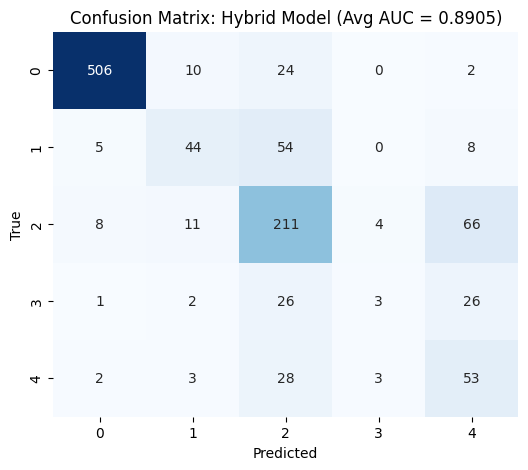

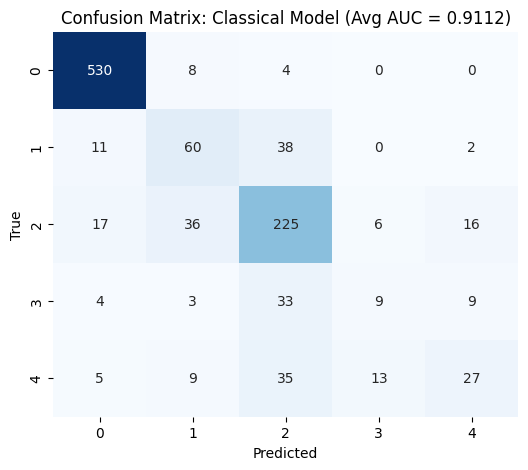

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)